In [19]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import re 
from tqdm import tqdm 
import matplotlib as mpl 
import seaborn as sns 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from preprocessing_functions import *

In [20]:
!pwd

/ocean/projects/atm200007p/jlin96/ams_talk


In [21]:
sp_path = "/ocean/projects/atm200007p/jlin96/longSPrun_o3/"
sp_list = os.popen(" ".join(["ls", sp_path + "*.h1.000*"])).read().splitlines()
sp_data = xr.open_mfdataset(sp_list[52:54])
hyam = sp_data['hyam'].mean('time')
hybm = sp_data['hybm'].mean('time')
nnps = sp_data['NNPS'].mean('time')
sp_pg = hyam*1e5 + nnps*hybm
vert_coord = np.mean(sp_pg, axis = (1,2)).values

In [91]:
hsr_results_root = '/ocean/projects/atm200007p/jlin96/ams_talk/hsr/coupled_results/'
baseline_results_root = '/ocean/projects/atm200007p/jlin96/ams_talk/baseline/coupled_results/'

hsr_models_root = '/ocean/projects/atm200007p/jlin96/ams_talk/hsr/coupling_folder/h5_models/'
baseline_models_root = '/ocean/projects/atm200007p/jlin96/ams_talk/baseline/coupling_folder/h5_models/'

def get_hsr_model(model_num):
    model_num = str(model_num).zfill(3)
    model_path = hsr_models_root + 'hsr_model_' + model_num + '.h5'
    model = load_model(model_path, compile = False)
    return model

def get_baseline_model(model_num):
    model_num = str(model_num).zfill(3)
    model_path = baseline_models_root + 'baseline_model_' + model_num + '.h5'
    model = load_model(model_path, compile = False)
    return model

def cleanPaste(paste):
    paste = re.sub("\n", "", paste)
    paste = paste.split(" ")
    paste = np.array([float(x) for x in paste if len(x)>0])
    return paste[:,np.newaxis].T

def get_summary_diffs(arr_1, arr_2):
    arr = (arr_1 - arr_2).flatten()
    return pd.Series(arr).describe()

def pred2sample(preds):
    heating_mean = preds[:, 0:30]
    moistening_mean = preds[:, 30:60]
    heating_std = np.exp(preds[:, 60:90])
    moistening_std = np.exp(preds[:, 90:107])

    heating_samples = np.random.normal(loc = heating_mean, scale = heating_std)
    moistening_samples = np.random.normal(loc = moistening_mean[:, 13:30], scale = moistening_std)

    return np.concatenate((heating_samples, moistening_mean[:, 0:13], moistening_samples), axis = 1)

In [31]:
hsr_norm_path = '/ocean/projects/atm200007p/jlin96/ams_talk/hsr/coupling_folder/norm_files/'
baseline_norm_path = '/ocean/projects/atm200007p/jlin96/ams_talk/baseline/coupling_folder/norm_files/'

hsr_inp_sub = np.loadtxt(hsr_norm_path + 'inp_sub.txt')
hsr_inp_div = np.loadtxt(hsr_norm_path + 'inp_div.txt')
hsr_out_scale = np.loadtxt(hsr_norm_path + 'out_scale.txt')

baseline_inp_sub = np.loadtxt(baseline_norm_path + 'inp_sub.txt')
baseline_inp_div = np.loadtxt(baseline_norm_path + 'inp_div.txt')
baseline_out_scale = np.loadtxt(baseline_norm_path + 'out_scale.txt')

assert(np.array_equal(hsr_inp_sub, baseline_inp_sub))
assert(np.array_equal(hsr_inp_div, baseline_inp_div))

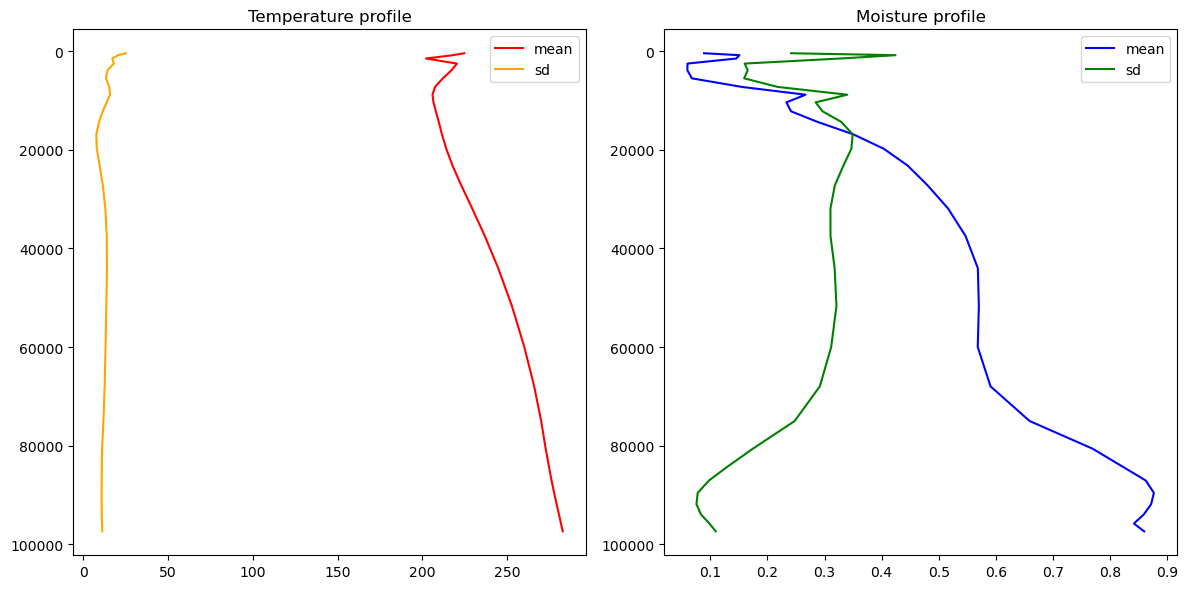

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Temperature profile
axs[0].plot(hsr_inp_sub[0:30], vert_coord, label="mean", color="red")
axs[0].plot(hsr_inp_div[0:30], vert_coord, label="sd", color="orange")
axs[0].legend()
axs[0].set_title("Temperature profile")
axs[0].invert_yaxis()

# Plot 2: Moisture profile
axs[1].plot(hsr_inp_sub[30:60], vert_coord, label="mean", color="blue")
axs[1].plot(hsr_inp_div[30:60], vert_coord, label="sd", color="green")
axs[1].legend()
axs[1].set_title("Moisture profile")
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [63]:
hsr_model_003 = load_model(hsr_models_root + 'hsr_model_003.h5', compile = False)
baseline_model_004 = load_model(baseline_models_root + 'baseline_model_004.h5', compile = False)

In [65]:
type(hsr_model_003)

keras.engine.sequential.Sequential

In [66]:
type(baseline_model_004)

keras.engine.sequential.Sequential

### Baseline brain debug check

In [42]:
logfile_inp_sub = """224.8395       218.0284       202.1898
   220.4915       217.2750       212.1913       207.5543       206.0504
   206.6532       208.0300       209.7850       211.6288       214.2012
   217.8754       223.0441       229.5400       236.9475       244.8735
   252.9694       260.2810       266.1000       270.2316       272.8809
   274.8942       276.3674       277.8780       279.3574       280.7314
   281.9075       282.9821      8.9034602E-02  0.1509468      0.1454910
  6.0026687E-02  5.9860688E-02  6.7724019E-02  0.1552179      0.2666968
  0.2331976      0.2412927      0.2876765      0.3502460      0.4037260
  0.4455744      0.4804952      0.5164604      0.5469325      0.5684704
  0.5702290      0.5683118      0.5906652      0.6591080      0.7693639
  0.8239162      0.8625716      0.8767350      0.8718790      0.8590207
  0.8417650      0.8596873      7.3587711E-07 -9.0279889E-07 -9.8332739E-06
  1.5182758E-05 -1.8729311E-06 -2.9149538E-07 -1.0773446E-06 -9.1986925E-07
  1.4720079E-07 -4.6862397E-07 -1.1492997E-06 -2.5430763E-06 -3.4832017E-06
 -4.2752563E-06 -4.6760915E-06 -4.8712222E-06 -4.4934363E-06 -3.1997631E-06
 -1.3850407E-06 -3.2002384E-07 -5.5868179E-07 -2.4527701E-06 -3.4172174E-06
  1.2753318E-06  3.2624966E-06  5.6648296E-06  6.7010178E-06  6.6178018E-06
  5.9225567E-06  4.8104448E-06  0.0000000E+00  0.0000000E+00 -1.8535676E-13
  1.0662878E-13 -1.3039010E-14 -1.0886288E-14 -2.2928160E-14 -2.0843343E-14
 -4.0320107E-13 -2.7229529E-12 -1.3711391E-11 -5.3659566E-11 -1.7300791E-10
 -4.5743437E-10 -9.0607272E-10 -1.3552185E-09 -1.8163743E-09 -2.2082680E-09
 -2.5300038E-09 -2.7341795E-09 -2.1283009E-09  4.6946241E-10  3.9244292E-09
  3.2214555E-09  3.4352385E-09  3.6475429E-09  3.5806871E-09  4.5633270E-09
  4.6050874E-09  5.1578093E-09   98339.97       326.0704       17.55597
   72.88867      0.2187141      6.3081026E-02  7.5854085E-02 -5.9440691E-02
  6.6315196E-02 -3.4277719E-02  2.8658282E-02 -5.5440191E-02 -8.5552916E-02
 -0.2093354     -0.4066070     -0.5617532     -0.5769261     -0.3936160
 -8.5498281E-02  0.1547814      0.1958310      0.1173239      5.7428680E-02
  2.8460763E-02  2.2439240E-02  3.6029249E-02  0.1003580      0.1727000
  0.1880806      0.1834754      0.1946791      0.2303295      0.2807219
  0.3026728      7.2801263E-06  7.7239574E-06  6.9310645E-06  5.1393354E-06
  3.4736961E-06  2.2656768E-06  1.4136884E-06  9.8032353E-07  7.3508869E-07
  5.5578994E-07  4.1761606E-07  3.0672041E-07  2.1885269E-07  1.4448001E-07
  9.1027218E-08  6.4508264E-08  5.2572709E-08  4.4395986E-08  3.8210029E-08
  3.4693116E-08  3.1728195E-08  2.8782390E-08  2.6371726E-08  2.4774712E-08
  2.3804283E-08  2.2932369E-08  2.2132383E-08  2.1410480E-08  2.0787814E-08
  2.0290791E-08  0.0000000E+00"""

logfile_inp_sub = cleanPaste(logfile_inp_sub)

logfile_inp_div = """24.87870       20.45608       17.04918
   17.93386       14.17427       13.26336       15.24338       15.72007
   13.70485       11.41045       9.202378       7.585543       7.885203
   9.565273       11.44268       12.94470       13.75611       13.87045
   13.52072       13.02865       12.51554       11.79508       11.00286
   10.80916       10.74734       10.70493       10.71876       10.81148
   10.96931       11.11220      0.2413484      0.4242707      0.3271155
  0.1602023      0.1654771      0.1592613      0.2179290      0.3398235
  0.2844254      0.2965528      0.3293178      0.3492658      0.3470050
  0.3331141      0.3180518      0.3103359      0.3104367      0.3177115
  0.3208451      0.3116293      0.2917692      0.2476545      0.1745373
  0.1284621      9.7583756E-02  7.7897243E-02  7.5676978E-02  8.3654776E-02
  9.8456427E-02  0.1095534      4.2081603E-05  3.0305013E-05  2.8919230E-05
  2.1749269E-05  8.8094475E-06  6.6265384E-06  6.7491928E-06  8.5299353E-06
  9.1184957E-06  9.8267228E-06  1.1425306E-05  1.3998900E-05  1.7117509E-05
  2.1365644E-05  2.8598253E-05  3.7312617E-05  4.5689816E-05  5.1673145E-05
  5.3445965E-05  5.3805838E-05  5.3084907E-05  5.4599255E-05  5.4649467E-05
  5.5795543E-05  4.9060138E-05  4.2152315E-05  3.6876983E-05  3.5616002E-05
  3.9046019E-05  5.3490214E-05   1.000000       1.000000      1.7276011E-12
  8.9812305E-13  3.5979490E-13  2.1994826E-12  2.6753933E-12  3.7631408E-12
  1.2667675E-11  4.4450162E-11  1.4691107E-10  4.3695317E-10  1.1692379E-09
  2.8312428E-09  5.6052905E-09  8.8189180E-09  1.2367996E-08  1.5405000E-08
  1.8037976E-08  2.1508578E-08  2.6154190E-08  3.2819560E-08  4.0568363E-08
  4.7724509E-08  4.7186834E-08  4.6210783E-08  4.3628308E-08  3.8679929E-08
  3.7596060E-08  4.6804253E-08   1558.279       422.9388       15.84890
   74.74619       15.38309       11.28652       8.961798       7.324714
   5.866265       5.231980       5.425526       6.165736       6.930577
   7.931077       9.243393       10.57106       11.50617       11.84912
   11.59785       10.83593       9.685538       8.339402       7.080352
   6.186744       5.714844       5.534291       5.552164       5.705149
   5.929893       6.216343       6.394514       6.381163       6.168697
   5.810932      9.9691181E-07  1.8758202E-06  1.7534895E-06  7.2020146E-07
  5.8134049E-07  8.0812083E-07  7.9915355E-07  6.4931771E-07  5.2750067E-07
  4.3355456E-07  3.4215142E-07  2.4451484E-07  1.6252064E-07  9.2474394E-08
  4.3479652E-08  2.0480284E-08  1.0541084E-08  4.9545914E-09  4.3816879E-09
  5.3279736E-09  5.8611755E-09  5.9286487E-09  5.8991931E-09  5.9948793E-09
  5.9698992E-09  5.9796132E-09  6.0184355E-09  6.0764322E-09  6.1271765E-09
  6.1513981E-09  0.5351467"""

logfile_inp_div = cleanPaste(logfile_inp_div)

logfile_out_scale = """1004.000       1004.000       1004.000
   1004.000       1004.000       1004.000       1004.000       1004.000
   1004.000       1004.000       1004.000       1004.000       1004.000
   1004.000       1004.000       1004.000       1004.000       1004.000
   1004.000       1004.000       1004.000       1004.000       1004.000
   1004.000       1004.000       1004.000       1004.000       1004.000
   1004.000       1004.000       2500000.       2500000.       2500000.
   2500000.       2500000.       2500000.       2500000.       2500000.
   2500000.       2500000.       2500000.       2500000.       2500000.
   2500000.       2500000.       2500000.       2500000.       2500000.
   2500000.       2500000.       2500000.       2500000.       2500000.
   2500000.       2500000.       2500000.       2500000.       2500000.
   2500000.       2500000."""

logfile_out_scale = cleanPaste(logfile_out_scale)

In [52]:
pd.Series((baseline_inp_sub - logfile_inp_sub).flatten()).describe()

count    1.850000e+02
mean    -2.132438e-05
std      2.927513e-04
min     -3.978859e-03
25%     -1.134686e-09
50%     -1.093425e-18
75%      1.323766e-13
max      4.775020e-05
dtype: float64

In [53]:
pd.Series((baseline_inp_div - logfile_inp_div).flatten()).describe()

count    1.850000e+02
mean     1.433999e-06
std      1.716994e-05
min     -8.217798e-06
25%     -1.644337e-12
50%      4.919418e-20
75%      1.348830e-08
max      2.299958e-04
dtype: float64

In [54]:
pd.Series((baseline_out_scale - logfile_out_scale).flatten()).describe()

count    60.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
dtype: float64

In [55]:
logfile_pre_norm = """246.6720       231.9619       217.0479
   238.3783       231.9308       229.5559       229.3577       228.4086
   227.2230       226.1934       225.0445       222.7293       220.6632
   217.7152       217.0008       218.2279       223.6776       231.7807
   240.5515       248.4644       254.5219       258.6828       262.0081
   264.5941       265.7408       267.4874       269.2228       270.7819
   272.1668       273.3862      2.0437694E-05  2.0561165E-04  2.2284258E-03
  3.0260195E-04  9.5728418E-04  1.7247029E-03  2.2253152E-03  3.0297982E-03
  4.1024620E-03  5.4769125E-03  7.5559462E-03  1.2588518E-02  2.6884411E-02
  8.4374934E-02  0.2010073      0.5002134      0.6695683      0.7219777
  0.8130009      0.7909316      0.6772863      0.6209309      0.8095004
  0.8643922      0.9599643      0.9287811      0.8784087      0.8603421
  0.8303676      0.8392467     -5.5240771E-06 -3.7624334E-06  6.9201283E-06
 -6.9989110E-06 -2.9172240E-06 -1.2507558E-06 -4.6246183E-07 -1.0768546E-06
 -6.5792045E-07 -6.7042144E-08  2.4682953E-08 -3.0650423E-07 -9.9652162E-08
 -9.7188376E-07 -2.1667229E-06 -5.1909583E-06 -6.3334264E-06 -7.7150253E-06
 -7.2700986E-06 -6.0703305E-06 -5.6436061E-06 -5.5077817E-06 -5.2238606E-06
 -6.4357778E-06 -5.9913532E-06 -3.7692445E-09 -8.6611021E-07 -2.2833535E-06
 -3.9535121E-06  2.3181259E-05  0.0000000E+00  0.0000000E+00 -7.5746675E-15
  3.7510511E-15  1.6267994E-15 -2.4622548E-14  8.2084430E-15  2.3191222E-14
  3.0426033E-14 -3.6769311E-14 -2.1387760E-14 -3.5025036E-14  4.7783781E-14
  1.3322435E-13  1.3251670E-12 -2.3031483E-12  2.3733591E-11  9.5084163E-11
 -7.1870641E-11  5.3346046E-11  2.3786605E-11  3.4583406E-11  5.4584343E-10
 -7.0692885E-10  4.1084292E-09 -1.6427079E-09 -2.3067019E-09 -3.5410386E-09
  8.8033056E-09  1.2570695E-08   99649.20       483.1930       4.957146
   11.69294      -1.302314      -1.412991     -0.4959789     -0.6785737
  -2.029298      -2.072770      -2.234632      -2.834947      -3.319509
  -3.704333      -4.163391      -4.684104      -4.803102      -4.266442
  -3.094877      -1.283807     -3.8139362E-02 -0.1702935     -0.8562905
  -1.512169      -1.631121      -1.703190      -1.849357      -1.885191
  -1.910872      -1.927347      -2.073101      -2.004983      -1.997097
  -1.960028      4.6249070E-06  4.1202206E-06  3.6327847E-06  3.2480148E-06
  2.9510561E-06  2.5074335E-06  2.0773912E-06  1.6446808E-06  1.3223113E-06
  1.0629776E-06  8.2872373E-07  6.2242668E-07  4.4905812E-07  2.7102692E-07
  1.4149505E-07  8.3299042E-08  5.8047672E-08  4.1395150E-08  3.0426385E-08
  2.4902036E-08  2.1211006E-08  1.9123114E-08  1.8105592E-08  1.7443080E-08
  1.7042881E-08  1.6669782E-08  1.6326830E-08  1.6016882E-08  1.5768110E-08
  1.5561355E-08  0.3418244"""

logfile_pre_norm = cleanPaste(logfile_pre_norm)

logfile_post_norm = """0.8775587      0.6811416      0.8714852
  0.9973763       1.033977       1.309217       1.430348       1.422269
   1.500915       1.591817       1.658212       1.463369      0.8195104
 -1.6751485E-02 -0.5281413     -0.8738768     -0.9646603     -0.9439347
 -0.9184345     -0.9069755     -0.9251044     -0.9791198     -0.9881828
 -0.9529054     -0.9887582     -0.9706393     -0.9454969     -0.9202653
 -0.8879920     -0.8635395     -0.3688202     -0.3552948     -0.4379573
 -0.3728043     -0.3559612     -0.4144089     -0.7020294     -0.7758939
 -0.8054662     -0.7951897     -0.8506086     -0.9667636      -1.085983
  -1.084311     -0.8787496     -5.2352872E-02  0.3950430      0.4831658
  0.7566639      0.7143738      0.2968823     -0.1541548      0.2299595
  0.3150814      0.9980419      0.6681374      8.6282901E-02  1.5796289E-02
 -0.1157611     -0.1865810     -0.1487575     -9.4361767E-02  0.5793170
  -1.019881     -0.1185424     -0.1447604      9.1104634E-02 -1.8404046E-02
 -8.8295400E-02  4.0866300E-02  0.1027528      0.1597677      0.1976660
  0.1546114      8.7745525E-02 -8.5691130E-03 -4.0271338E-02 -8.7381206E-02
 -0.1101123     -0.1068714     -9.5788501E-02 -5.5953354E-02 -3.3058751E-02
 -0.1382030     -0.1886226     -0.1344790     -0.2051992     -0.2499201
 -0.2529341      0.3434425      0.0000000E+00  0.0000000E+00  0.1029069
 -0.1145475      4.0761579E-02 -6.2452233E-03  1.1638140E-02  1.1701546E-02
  3.4230988E-02  6.0431354E-02  9.3185648E-02  0.1227238      0.1480073
  0.1616137      0.1618824      0.1534106      0.1487798      0.1495198
  0.1362754      0.1296006      8.2284614E-02 -1.3250605E-02 -8.3281294E-02
 -8.2313769E-02  1.4266493E-02 -0.1144809     -0.1349443     -0.2095238
  0.1116664      0.1583806      0.8401796      0.3715020     -0.7949339
 -0.8187137     -9.8876633E-02 -0.1307818     -6.3807838E-02 -8.4526591E-02
 -0.3572313     -0.3896215     -0.4171559     -0.4507989     -0.4666215
 -0.4406713     -0.4064291     -0.3899657     -0.3672964     -0.3268450
 -0.2594773     -0.1327610     -2.4156664E-02 -3.4488980E-02 -0.1290500
 -0.2490211     -0.2893448     -0.3142623     -0.3511632     -0.3607077
 -0.3539613     -0.3395602     -0.3546447     -0.3502986     -0.3692545
 -0.3893870      -2.663445      -1.921152      -1.880980      -2.626100
 -0.8990256      0.2991590      0.8305072       1.023162       1.113217
   1.169836       1.201537       1.291154       1.416469       1.368454
   1.160723      0.9175057      0.5193928     -0.6056675      -1.776403
  -1.837674      -1.794382      -1.629254      -1.401231      -1.222983
  -1.132582      -1.047323     -0.9646283     -0.8876259     -0.8192524
 -0.7688393      0.6387489"""

logfile_post_norm = cleanPaste(logfile_post_norm)

logfile_output = """-5.739271640777588E-003 -4.355822224169970E-003
 -8.967798203229904E-004 -1.179224811494350E-003 -2.716602757573128E-003
 -1.215089578181505E-003 -8.267880766652524E-004 -8.750846609473228E-004
 -1.215845113620162E-003 -6.300152163021266E-004 -3.187280381098390E-004
 -9.677689522504807E-004 -5.291411653161049E-004 -1.537218224257231E-003
 -2.955311443656683E-003 -5.633133929222822E-003 -7.856950163841248E-003
 -8.184073492884636E-003 -6.438655778765678E-003 -5.660776980221272E-003
 -5.064032040536404E-003 -5.125825293362141E-003 -6.970957852900028E-003
 -8.011714555323124E-003 -4.962068051099777E-003 -4.086685832589865E-003
 -4.154605325311422E-003 -4.508798941969872E-003 -4.723177757114172E-003
  2.524461224675179E-002 -3.081572546612837E-031  2.113504988541169E-030
 -4.996076086172252E-007  5.354898462428537E-007 -1.494249346478682E-007
 -1.018674083752558E-006 -8.783361522546329E-007 -1.591624595675967E-006
 -4.163857738603838E-007  2.268225216539577E-006 -2.151015360141173E-005
 -3.462671884335577E-006 -1.474741147831082E-004  1.838298048824072E-004
  3.235319163650274E-004  1.286522019654512E-004 -2.392334863543510E-005
 -5.665370263159275E-004 -1.006971579045057E-003 -9.339074604213238E-004
 -3.142231144011021E-004 -3.870578366331756E-004 -7.597962394356728E-004
 -1.036988105624914E-003 -2.769452519714832E-003 -2.344101667404175E-003
 -1.643253490328789E-004  4.943823441863060E-004  8.177624084055424E-003
  2.001723460853100E-002"""

logfile_output = cleanPaste(logfile_output)

logfile_out_post_scale = """-5.716406016710745E-006 -4.338468350766902E-006
 -8.932069923535762E-007 -1.174526704675648E-006 -2.705779639017060E-006
 -1.210248583846121E-006 -8.234941002641956E-007 -8.715982678758196E-007
 -1.211001109183428E-006 -6.275051955200465E-007 -3.174582052886842E-007
 -9.639132990542635E-007 -5.270330331833714E-007 -1.531093848861784E-006
 -2.943537294478768E-006 -5.610691164564564E-006 -7.825647573547059E-006
 -8.151467622395056E-006 -6.413003763710835E-006 -5.638224083885729E-006
 -5.043856614080083E-006 -5.105403678647550E-006 -6.943185112450228E-006
 -7.979795373827812E-006 -4.942298855677069E-006 -4.070404215726957E-006
 -4.138053112859983E-006 -4.490835599571585E-006 -4.704360315850769E-006
  2.514403610234241E-005 -1.232629018645135E-037  8.454019954164677E-037
 -1.998430434468901E-013  2.141959384971415E-013 -5.976997385914728E-014
 -4.074696335010231E-013 -3.513344609018532E-013 -6.366498382703867E-013
 -1.665543095441535E-013  9.072900866158307E-013 -8.604061440564692E-012
 -1.385068753734231E-012 -5.898964591324329E-011  7.353192195296288E-011
  1.294127665460110E-010  5.146088078618049E-011 -9.569339454174041E-012
 -2.266148105263710E-010 -4.027886316180229E-010 -3.735629841685295E-010
 -1.256892457604408E-010 -1.548231346532702E-010 -3.039184957742691E-010
 -4.147952422499656E-010 -1.107781007885933E-009 -9.376406669616698E-010
 -6.573013961315156E-011  1.977529376745224E-010  3.271049633622169E-009
  8.006893843412400E-009"""

logfile_out_post_scale = cleanPaste(logfile_out_post_scale)

In [62]:
pd.Series(((logfile_pre_norm - logfile_inp_sub)/logfile_inp_div - logfile_post_norm).flatten()).describe()

count    1.850000e+02
mean     2.712821e-08
std      1.571362e-06
min     -7.392230e-06
25%     -6.779773e-08
50%     -4.668356e-11
75%      3.468754e-08
max      6.792610e-06
dtype: float64

In [67]:
logfile_post_norm.shape

(1, 185)

In [71]:
model_predict = baseline_model_004.predict(logfile_post_norm)

1/1 [==============================] - 0s 30ms/step


In [72]:
pd.Series((model_predict - logfile_output).flatten()).describe()

count    6.000000e+01
mean     1.247157e-09
std      3.420402e-09
min     -1.303852e-08
25%      0.000000e+00
50%      4.656613e-10
75%      2.706656e-09
max      1.117587e-08
dtype: float64

In [73]:
pd.Series((model_predict/logfile_out_scale - logfile_out_post_scale).flatten()).describe()

count    6.000000e+01
mean     8.070041e-13
std      2.775822e-12
min     -1.298657e-11
25%      0.000000e+00
50%      1.117587e-15
75%      1.217491e-12
max      1.113135e-11
dtype: float64

### HSR brain debug check

In [75]:
logfile_inp_sub = """224.8395       218.0284       202.1898    
   220.4915       217.2750       212.1913       207.5543       206.0504    
   206.6532       208.0300       209.7850       211.6288       214.2012    
   217.8754       223.0441       229.5400       236.9475       244.8735    
   252.9694       260.2810       266.1000       270.2316       272.8809    
   274.8942       276.3674       277.8780       279.3574       280.7314    
   281.9075       282.9821      8.9034602E-02  0.1509468      0.1454910    
  6.0026687E-02  5.9860688E-02  6.7724019E-02  0.1552179      0.2666968    
  0.2331976      0.2412927      0.2876765      0.3502460      0.4037260    
  0.4455744      0.4804952      0.5164604      0.5469325      0.5684704    
  0.5702290      0.5683118      0.5906652      0.6591080      0.7693639    
  0.8239162      0.8625716      0.8767350      0.8718790      0.8590207    
  0.8417650      0.8596873      7.3587711E-07 -9.0279889E-07 -9.8332739E-06
  1.5182758E-05 -1.8729311E-06 -2.9149538E-07 -1.0773446E-06 -9.1986925E-07
  1.4720079E-07 -4.6862397E-07 -1.1492997E-06 -2.5430763E-06 -3.4832017E-06
 -4.2752563E-06 -4.6760915E-06 -4.8712222E-06 -4.4934363E-06 -3.1997631E-06
 -1.3850407E-06 -3.2002384E-07 -5.5868179E-07 -2.4527701E-06 -3.4172174E-06
  1.2753318E-06  3.2624966E-06  5.6648296E-06  6.7010178E-06  6.6178018E-06
  5.9225567E-06  4.8104448E-06  0.0000000E+00  0.0000000E+00 -1.8535676E-13
  1.0662878E-13 -1.3039010E-14 -1.0886288E-14 -2.2928160E-14 -2.0843343E-14
 -4.0320107E-13 -2.7229529E-12 -1.3711391E-11 -5.3659566E-11 -1.7300791E-10
 -4.5743437E-10 -9.0607272E-10 -1.3552185E-09 -1.8163743E-09 -2.2082680E-09
 -2.5300038E-09 -2.7341795E-09 -2.1283009E-09  4.6946241E-10  3.9244292E-09
  3.2214555E-09  3.4352385E-09  3.6475429E-09  3.5806871E-09  4.5633270E-09
  4.6050874E-09  5.1578093E-09   98339.97       326.0704       17.55597    
   72.88867      0.2187141      6.3081026E-02  7.5854085E-02 -5.9440691E-02
  6.6315196E-02 -3.4277719E-02  2.8658282E-02 -5.5440191E-02 -8.5552916E-02
 -0.2093354     -0.4066070     -0.5617532     -0.5769261     -0.3936160    
 -8.5498281E-02  0.1547814      0.1958310      0.1173239      5.7428680E-02
  2.8460763E-02  2.2439240E-02  3.6029249E-02  0.1003580      0.1727000    
  0.1880806      0.1834754      0.1946791      0.2303295      0.2807219    
  0.3026728      7.2801263E-06  7.7239574E-06  6.9310645E-06  5.1393354E-06
  3.4736961E-06  2.2656768E-06  1.4136884E-06  9.8032353E-07  7.3508869E-07
  5.5578994E-07  4.1761606E-07  3.0672041E-07  2.1885269E-07  1.4448001E-07
  9.1027218E-08  6.4508264E-08  5.2572709E-08  4.4395986E-08  3.8210029E-08
  3.4693116E-08  3.1728195E-08  2.8782390E-08  2.6371726E-08  2.4774712E-08
  2.3804283E-08  2.2932369E-08  2.2132383E-08  2.1410480E-08  2.0787814E-08
  2.0290791E-08  0.0000000E+00"""

logfile_inp_sub = cleanPaste(logfile_inp_sub)

logfile_inp_div = """24.87870       20.45608       17.04918    
   17.93386       14.17427       13.26336       15.24338       15.72007    
   13.70485       11.41045       9.202378       7.585543       7.885203    
   9.565273       11.44268       12.94470       13.75611       13.87045    
   13.52072       13.02865       12.51554       11.79508       11.00286    
   10.80916       10.74734       10.70493       10.71876       10.81148    
   10.96931       11.11220      0.2413484      0.4242707      0.3271155    
  0.1602023      0.1654771      0.1592613      0.2179290      0.3398235    
  0.2844254      0.2965528      0.3293178      0.3492658      0.3470050    
  0.3331141      0.3180518      0.3103359      0.3104367      0.3177115    
  0.3208451      0.3116293      0.2917692      0.2476545      0.1745373    
  0.1284621      9.7583756E-02  7.7897243E-02  7.5676978E-02  8.3654776E-02
  9.8456427E-02  0.1095534      4.2081603E-05  3.0305013E-05  2.8919230E-05
  2.1749269E-05  8.8094475E-06  6.6265384E-06  6.7491928E-06  8.5299353E-06
  9.1184957E-06  9.8267228E-06  1.1425306E-05  1.3998900E-05  1.7117509E-05
  2.1365644E-05  2.8598253E-05  3.7312617E-05  4.5689816E-05  5.1673145E-05
  5.3445965E-05  5.3805838E-05  5.3084907E-05  5.4599255E-05  5.4649467E-05
  5.5795543E-05  4.9060138E-05  4.2152315E-05  3.6876983E-05  3.5616002E-05
  3.9046019E-05  5.3490214E-05   1.000000       1.000000      1.7276011E-12
  8.9812305E-13  3.5979490E-13  2.1994826E-12  2.6753933E-12  3.7631408E-12
  1.2667675E-11  4.4450162E-11  1.4691107E-10  4.3695317E-10  1.1692379E-09
  2.8312428E-09  5.6052905E-09  8.8189180E-09  1.2367996E-08  1.5405000E-08
  1.8037976E-08  2.1508578E-08  2.6154190E-08  3.2819560E-08  4.0568363E-08
  4.7724509E-08  4.7186834E-08  4.6210783E-08  4.3628308E-08  3.8679929E-08
  3.7596060E-08  4.6804253E-08   1558.279       422.9388       15.84890    
   74.74619       15.38309       11.28652       8.961798       7.324714    
   5.866265       5.231980       5.425526       6.165736       6.930577    
   7.931077       9.243393       10.57106       11.50617       11.84912    
   11.59785       10.83593       9.685538       8.339402       7.080352    
   6.186744       5.714844       5.534291       5.552164       5.705149    
   5.929893       6.216343       6.394514       6.381163       6.168697    
   5.810932      9.9691181E-07  1.8758202E-06  1.7534895E-06  7.2020146E-07
  5.8134049E-07  8.0812083E-07  7.9915355E-07  6.4931771E-07  5.2750067E-07
  4.3355456E-07  3.4215142E-07  2.4451484E-07  1.6252064E-07  9.2474394E-08
  4.3479652E-08  2.0480284E-08  1.0541084E-08  4.9545914E-09  4.3816879E-09
  5.3279736E-09  5.8611755E-09  5.9286487E-09  5.8991931E-09  5.9948793E-09
  5.9698992E-09  5.9796132E-09  6.0184355E-09  6.0764322E-09  6.1271765E-09
  6.1513981E-09  0.5351467"""

logfile_inp_div = cleanPaste(logfile_inp_div)

logfile_out_scale = """1004.000       1004.000       1004.000    
   1004.000       1004.000       1004.000       1004.000       1004.000    
   1004.000       1004.000       1004.000       1004.000       1004.000    
   1004.000       1004.000       1004.000       1004.000       1004.000    
   1004.000       1004.000       1004.000       1004.000       1004.000    
   1004.000       1004.000       1004.000       1004.000       1004.000    
   1004.000       1004.000       2500000.       2500000.       2500000.    
   2500000.       2500000.       2500000.       2500000.       2500000.    
   2500000.       2500000.       2500000.       2500000.       2500000.    
   2500000.       2500000.       2500000.       2500000.       2500000.    
   2500000.       2500000.       2500000.       2500000.       2500000.    
   2500000.       2500000.       2500000.       2500000.       2500000.    
   2500000.       2500000.       1.000000       1.000000       1.000000    
   1.000000       1.000000       1.000000       1.000000       1.000000    
   1.000000       1.000000       1.000000       1.000000       1.000000    
   1.000000       1.000000       1.000000       1.000000       1.000000    
   1.000000       1.000000       1.000000       1.000000       1.000000    
   1.000000       1.000000       1.000000       1.000000       1.000000    
   1.000000       1.000000       1.000000       1.000000       1.000000    
   1.000000       1.000000       1.000000       1.000000       1.000000    
   1.000000       1.000000       1.000000       1.000000       1.000000    
   1.000000       1.000000       1.000000       1.000000"""

logfile_out_scale = cleanPaste(logfile_out_scale)

In [77]:
get_summary_diffs(hsr_inp_sub, logfile_inp_sub)

count    1.850000e+02
mean    -2.132438e-05
std      2.927513e-04
min     -3.978859e-03
25%     -1.134686e-09
50%     -1.093425e-18
75%      1.323766e-13
max      4.775020e-05
dtype: float64

In [78]:
get_summary_diffs(hsr_inp_div, logfile_inp_div)

count    1.850000e+02
mean     1.433999e-06
std      1.716994e-05
min     -8.217798e-06
25%     -1.644337e-12
50%      4.919418e-20
75%      1.348830e-08
max      2.299958e-04
dtype: float64

In [79]:
get_summary_diffs(hsr_out_scale, logfile_out_scale)

count    107.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [85]:
logfile_pre_norm = """246.6720       231.9619       217.0479    
   238.3783       231.9308       229.5559       229.3577       228.4086    
   227.2230       226.1934       225.0445       222.7293       220.6632    
   217.7152       217.0008       218.2279       223.6776       231.7807    
   240.5515       248.4644       254.5219       258.6828       262.0081    
   264.5941       265.7408       267.4874       269.2228       270.7819    
   272.1668       273.3862      2.0437694E-05  2.0561165E-04  2.2284258E-03
  3.0260195E-04  9.5728418E-04  1.7247029E-03  2.2253152E-03  3.0297982E-03
  4.1024620E-03  5.4769125E-03  7.5559462E-03  1.2588518E-02  2.6884411E-02
  8.4374934E-02  0.2010073      0.5002134      0.6695683      0.7219777    
  0.8130009      0.7909316      0.6772863      0.6209309      0.8095004    
  0.8643922      0.9599643      0.9287811      0.8784087      0.8603421    
  0.8303676      0.8392467     -5.5240771E-06 -3.7624334E-06  6.9201283E-06
 -6.9989110E-06 -2.9172240E-06 -1.2507558E-06 -4.6246183E-07 -1.0768546E-06
 -6.5792045E-07 -6.7042144E-08  2.4682953E-08 -3.0650423E-07 -9.9652162E-08
 -9.7188376E-07 -2.1667229E-06 -5.1909583E-06 -6.3334264E-06 -7.7150253E-06
 -7.2700986E-06 -6.0703305E-06 -5.6436061E-06 -5.5077817E-06 -5.2238606E-06
 -6.4357778E-06 -5.9913532E-06 -3.7692445E-09 -8.6611021E-07 -2.2833535E-06
 -3.9535121E-06  2.3181259E-05  0.0000000E+00  0.0000000E+00 -7.5746675E-15
  3.7510511E-15  1.6267994E-15 -2.4622548E-14  8.2084430E-15  2.3191222E-14
  3.0426033E-14 -3.6769311E-14 -2.1387760E-14 -3.5025036E-14  4.7783781E-14
  1.3322435E-13  1.3251670E-12 -2.3031483E-12  2.3733591E-11  9.5084163E-11
 -7.1870641E-11  5.3346046E-11  2.3786605E-11  3.4583406E-11  5.4584343E-10
 -7.0692885E-10  4.1084292E-09 -1.6427079E-09 -2.3067019E-09 -3.5410386E-09
  8.8033056E-09  1.2570695E-08   99649.20       483.1930       4.957146    
   11.69294      -1.302314      -1.412991     -0.4959789     -0.6785737    
  -2.029298      -2.072770      -2.234632      -2.834947      -3.319509    
  -3.704333      -4.163391      -4.684104      -4.803102      -4.266442    
  -3.094877      -1.283807     -3.8139362E-02 -0.1702935     -0.8562905    
  -1.512169      -1.631121      -1.703190      -1.849357      -1.885191    
  -1.910872      -1.927347      -2.073101      -2.004983      -1.997097    
  -1.960028      4.6249070E-06  4.1202206E-06  3.6327847E-06  3.2480148E-06
  2.9510561E-06  2.5074335E-06  2.0773912E-06  1.6446808E-06  1.3223113E-06
  1.0629776E-06  8.2872373E-07  6.2242668E-07  4.4905812E-07  2.7102692E-07
  1.4149505E-07  8.3299042E-08  5.8047672E-08  4.1395150E-08  3.0426385E-08
  2.4902036E-08  2.1211006E-08  1.9123114E-08  1.8105592E-08  1.7443080E-08
  1.7042881E-08  1.6669782E-08  1.6326830E-08  1.6016882E-08  1.5768110E-08
  1.5561355E-08  0.3418244"""

logfile_pre_norm = cleanPaste(logfile_pre_norm)

logfile_post_norm = """0.8775587      0.6811416      0.8714852    
  0.9973763       1.033977       1.309217       1.430348       1.422269    
   1.500915       1.591817       1.658212       1.463369      0.8195104    
 -1.6751485E-02 -0.5281413     -0.8738768     -0.9646603     -0.9439347    
 -0.9184345     -0.9069755     -0.9251044     -0.9791198     -0.9881828    
 -0.9529054     -0.9887582     -0.9706393     -0.9454969     -0.9202653    
 -0.8879920     -0.8635395     -0.3688202     -0.3552948     -0.4379573    
 -0.3728043     -0.3559612     -0.4144089     -0.7020294     -0.7758939    
 -0.8054662     -0.7951897     -0.8506086     -0.9667636      -1.085983    
  -1.084311     -0.8787496     -5.2352872E-02  0.3950430      0.4831658    
  0.7566639      0.7143738      0.2968823     -0.1541548      0.2299595    
  0.3150814      0.9980419      0.6681374      8.6282901E-02  1.5796289E-02
 -0.1157611     -0.1865810     -0.1487575     -9.4361767E-02  0.5793170    
  -1.019881     -0.1185424     -0.1447604      9.1104634E-02 -1.8404046E-02
 -8.8295400E-02  4.0866300E-02  0.1027528      0.1597677      0.1976660    
  0.1546114      8.7745525E-02 -8.5691130E-03 -4.0271338E-02 -8.7381206E-02
 -0.1101123     -0.1068714     -9.5788501E-02 -5.5953354E-02 -3.3058751E-02
 -0.1382030     -0.1886226     -0.1344790     -0.2051992     -0.2499201    
 -0.2529341      0.3434425      0.0000000E+00  0.0000000E+00  0.1029069    
 -0.1145475      4.0761579E-02 -6.2452233E-03  1.1638140E-02  1.1701546E-02
  3.4230988E-02  6.0431354E-02  9.3185648E-02  0.1227238      0.1480073    
  0.1616137      0.1618824      0.1534106      0.1487798      0.1495198    
  0.1362754      0.1296006      8.2284614E-02 -1.3250605E-02 -8.3281294E-02
 -8.2313769E-02  1.4266493E-02 -0.1144809     -0.1349443     -0.2095238    
  0.1116664      0.1583806      0.8401796      0.3715020     -0.7949339    
 -0.8187137     -9.8876633E-02 -0.1307818     -6.3807838E-02 -8.4526591E-02
 -0.3572313     -0.3896215     -0.4171559     -0.4507989     -0.4666215    
 -0.4406713     -0.4064291     -0.3899657     -0.3672964     -0.3268450    
 -0.2594773     -0.1327610     -2.4156664E-02 -3.4488980E-02 -0.1290500    
 -0.2490211     -0.2893448     -0.3142623     -0.3511632     -0.3607077    
 -0.3539613     -0.3395602     -0.3546447     -0.3502986     -0.3692545    
 -0.3893870      -2.663445      -1.921152      -1.880980      -2.626100    
 -0.8990256      0.2991590      0.8305072       1.023162       1.113217    
   1.169836       1.201537       1.291154       1.416469       1.368454    
   1.160723      0.9175057      0.5193928     -0.6056675      -1.776403    
  -1.837674      -1.794382      -1.629254      -1.401231      -1.222983    
  -1.132582      -1.047323     -0.9646283     -0.8876259     -0.8192524    
 -0.7688393      0.6387489"""

logfile_post_norm = cleanPaste(logfile_post_norm)

logfile_output = """-4.086734727025032E-003 -2.929237438365817E-003
  2.496040426194668E-003 -3.615717403590679E-003 -2.955537289381027E-003
 -1.573753543198109E-003 -7.741578738205135E-004 -7.663702126592398E-004
 -6.336173973977566E-004 -3.568741376511753E-004 -1.099822111427784E-005
 -4.602726548910141E-004 -2.619193401187658E-004 -5.750604905188084E-004
 -2.272451296448708E-003 -5.146769341081381E-003 -6.141784135252237E-003
 -7.816349156200886E-003 -7.530837319791317E-003 -5.850067362189293E-003
 -4.741164389997721E-003 -5.618210881948471E-003 -4.342685453593731E-003
 -9.311305359005928E-003 -8.282562717795372E-003 -2.094895578920841E-003
 -1.833618385717273E-003 -3.262270241975784E-003 -5.398575682193041E-003
  2.388046681880951E-002 -9.904957551043481E-006  3.088983476118301E-006
 -3.959682999266079E-006  5.531228453037329E-006 -1.382298250973690E-006
 -2.879914063669275E-006  9.996756489272229E-007 -1.341243432761985E-006
  1.869061065917776E-006 -1.138391326094279E-006 -1.797936238290276E-005
  1.771595452737529E-005  5.106935714138672E-005  3.986721276305616E-005
 -1.515937474323437E-004  4.130331217311323E-005  2.646347275003791E-004
  2.442617551423609E-004 -1.515632029622793E-004 -3.445873735472560E-004
 -7.244948064908385E-004  8.238668087869883E-004  7.572835311293602E-004
  7.326094782911241E-004  4.336791113018990E-003 -2.457052469253540E-003
  1.999752363190055E-003  3.270384622737765E-003  1.327639259397984E-002
  2.625742740929127E-002  -12.8411960601807       -13.2567930221558     
  -10.7991161346436       -11.5196342468262       -16.6634788513184     
  -16.5328044891357       -15.1648244857788       -14.6517791748047     
  -14.5588130950928       -14.7071628570557       -14.7102832794189     
  -14.5334091186523       -13.9471235275269       -13.3607349395752     
  -13.1958255767822       -13.0872020721436       -12.9527950286865     
  -13.0224113464355       -13.3349390029907       -13.7821254730225     
  -13.8522996902466       -13.4920167922974       -11.8849487304688     
  -9.93252849578857       -9.43329429626465       -9.42311000823975     
  -9.62653923034668       -9.85706615447998       -10.0745525360107     
  -9.95652961730957       -15.6416645050049       -15.2513113021851     
  -14.8811769485474       -14.1377544403076       -13.7647428512573     
  -13.8794002532959       -13.8020067214966       -13.3354701995850     
  -12.5909137725830       -11.3591175079346       -10.0539789199829     
  -9.59792423248291       -9.00757598876953       -8.50775051116943     
  -8.30710983276367       -8.15503787994385       -7.84913539886475"""

logfile_output = cleanPaste(logfile_output)

logfile_out_post_scale = """-4.070452915363578E-006 -2.917567169687069E-006
  2.486096042026562E-006 -3.601312154970796E-006 -2.943762240419350E-006
 -1.567483608763056E-006 -7.710735795025035E-007 -7.633169448797209E-007
 -6.310930252965703E-007 -3.554523283378239E-007 -1.095440350027673E-008
 -4.584388992938387E-007 -2.608758367716791E-007 -5.727694128673390E-007
 -2.263397705626203E-006 -5.126264283945598E-006 -6.117314875749240E-006
 -7.785208322909249E-006 -7.500833983855893E-006 -5.826760320905670E-006
 -4.722275288842351E-006 -5.595827571661824E-006 -4.325383917922043E-006
 -9.274208524906302E-006 -8.249564459955549E-006 -2.086549381395260E-006
 -1.826313133184535E-006 -3.249273149378271E-006 -5.377067412542869E-006
  2.378532551674254E-005 -3.961983020417392E-012  1.235593390447320E-012
 -1.583873199706431E-012  2.212491381214931E-012 -5.529193003894761E-013
 -1.151965625467710E-012  3.998702595708892E-013 -5.364973731047940E-013
  7.476244263671106E-013 -4.553565304377117E-013 -7.191744953161105E-012
  7.086381810950115E-012  2.042774285655469E-011  1.594688510522247E-011
 -6.063749897293746E-011  1.652132486924529E-011  1.058538910001516E-010
  9.770470205694438E-011 -6.062528118491173E-011 -1.378349494189024E-010
 -2.897979225963354E-010  3.295467235147953E-010  3.029134124517441E-010
  2.930437913164497E-010  1.734716445207596E-009 -9.828209877014160E-010
  7.999009452760220E-010  1.308153849095106E-009  5.310557037591934E-009
  1.050297096371651E-008  -12.8411960601807       -13.2567930221558     
  -10.7991161346436       -11.5196342468262       -16.6634788513184     
  -16.5328044891357       -15.1648244857788       -14.6517791748047     
  -14.5588130950928       -14.7071628570557       -14.7102832794189     
  -14.5334091186523       -13.9471235275269       -13.3607349395752     
  -13.1958255767822       -13.0872020721436       -12.9527950286865     
  -13.0224113464355       -13.3349390029907       -13.7821254730225     
  -13.8522996902466       -13.4920167922974       -11.8849487304688     
  -9.93252849578857       -9.43329429626465       -9.42311000823975     
  -9.62653923034668       -9.85706615447998       -10.0745525360107     
  -9.95652961730957       -15.6416645050049       -15.2513113021851     
  -14.8811769485474       -14.1377544403076       -13.7647428512573     
  -13.8794002532959       -13.8020067214966       -13.3354701995850     
  -12.5909137725830       -11.3591175079346       -10.0539789199829     
  -9.59792423248291       -9.00757598876953       -8.50775051116943     
  -8.30710983276367       -8.15503787994385       -7.84913539886475"""

logfile_out_post_scale = cleanPaste(logfile_out_post_scale)

In [86]:
get_summary_diffs((logfile_pre_norm-logfile_inp_sub)/logfile_inp_div, logfile_post_norm)

count    1.850000e+02
mean     2.712821e-08
std      1.571362e-06
min     -7.392230e-06
25%     -6.779773e-08
50%     -4.668356e-11
75%      3.468754e-08
max      6.792610e-06
dtype: float64

In [92]:
hsr_preds = hsr_model_003.predict(logfile_post_norm)
hsr_samples = pred2sample(hsr_preds)

1/1 [==============================] - 0s 19ms/step


In [103]:
hsr_samples

array([[-4.08690642e-03, -2.92656341e-03,  2.49305292e-03,
        -3.59830577e-03, -2.95550400e-03, -1.57367966e-03,
        -7.73993127e-04, -7.66467575e-04, -6.33397767e-04,
        -3.56688766e-04, -1.15838059e-05, -4.60865231e-04,
        -2.60809791e-04, -5.72551758e-04, -2.27334864e-03,
        -5.14920962e-03, -6.14041089e-03, -7.81561298e-03,
        -7.53215538e-03, -5.85003273e-03, -4.74144621e-03,
        -5.61796511e-03, -4.35304516e-03, -9.30067003e-03,
        -8.24235210e-03, -2.15490672e-03, -1.87127565e-03,
        -3.33461419e-03, -5.45384824e-03,  2.38607116e-02,
        -9.90496028e-06,  3.08898279e-06, -3.95969028e-06,
         5.53122845e-06, -1.38230303e-06, -2.87991134e-06,
         9.99675422e-07, -1.34124457e-06,  1.86905720e-06,
        -1.13839371e-06, -1.79793788e-05,  1.77159400e-05,
         5.10694845e-05,  4.00355199e-05, -1.51741092e-04,
         4.12351577e-05,  2.64576112e-04,  2.43270223e-04,
        -1.52281197e-04, -3.45193872e-04, -7.23865478e-0

In [105]:
hsr_preds[0:60]

array([[-4.08672821e-03, -2.92923208e-03,  2.49603949e-03,
        -3.61571275e-03, -2.95553543e-03, -1.57375366e-03,
        -7.74157059e-04, -7.66371901e-04, -6.33618678e-04,
        -3.56873730e-04, -1.09981047e-05, -4.60271956e-04,
        -2.61918176e-04, -5.75060956e-04, -2.27244990e-03,
        -5.14677353e-03, -6.14178507e-03, -7.81634729e-03,
        -7.53083453e-03, -5.85006457e-03, -4.74116113e-03,
        -5.61820716e-03, -4.34268313e-03, -9.31130908e-03,
        -8.28255806e-03, -2.09488207e-03, -1.83361000e-03,
        -3.26226838e-03, -5.39858127e-03,  2.38804594e-02,
        -9.90496028e-06,  3.08898279e-06, -3.95969028e-06,
         5.53122845e-06, -1.38230303e-06, -2.87991134e-06,
         9.99675422e-07, -1.34124457e-06,  1.86905720e-06,
        -1.13839371e-06, -1.79793788e-05,  1.77159400e-05,
         5.10694845e-05,  3.98675911e-05, -1.51592962e-04,
         4.13039816e-05,  2.64634262e-04,  2.44261988e-04,
        -1.51560467e-04, -3.44590808e-04, -7.24497600e-0

In [112]:
np.exp(.5*hsr_preds[:,60:107])

array([[0.00162768, 0.00132228, 0.00451858, 0.00315169, 0.00024075,
        0.00025701, 0.00050933, 0.00065827, 0.00068959, 0.0006403 ,
        0.0006393 , 0.00069841, 0.00093631, 0.00125532, 0.00136321,
        0.00143929, 0.00153935, 0.00148669, 0.00127161, 0.00101683,
        0.00098177, 0.00117556, 0.00262553, 0.00696913, 0.00894512,
        0.00899079, 0.00812127, 0.00723711, 0.00649141, 0.006886  ,
        0.00040129, 0.00048778, 0.00058694, 0.00085119, 0.00102571,
        0.00096856, 0.00100677, 0.00127128, 0.00184467, 0.00341506,
        0.00655852, 0.0082383 , 0.011067  , 0.01420906, 0.01570847,
        0.01694947, 0.01975068]], dtype=float32)

In [99]:
logfile_output[:,0:60]

array([[-4.08673473e-03, -2.92923744e-03,  2.49604043e-03,
        -3.61571740e-03, -2.95553729e-03, -1.57375354e-03,
        -7.74157874e-04, -7.66370213e-04, -6.33617397e-04,
        -3.56874138e-04, -1.09982211e-05, -4.60272655e-04,
        -2.61919340e-04, -5.75060491e-04, -2.27245130e-03,
        -5.14676934e-03, -6.14178414e-03, -7.81634916e-03,
        -7.53083732e-03, -5.85006736e-03, -4.74116439e-03,
        -5.61821088e-03, -4.34268545e-03, -9.31130536e-03,
        -8.28256272e-03, -2.09489558e-03, -1.83361839e-03,
        -3.26227024e-03, -5.39857568e-03,  2.38804668e-02,
        -9.90495755e-06,  3.08898348e-06, -3.95968300e-06,
         5.53122845e-06, -1.38229825e-06, -2.87991406e-06,
         9.99675649e-07, -1.34124343e-06,  1.86906107e-06,
        -1.13839133e-06, -1.79793624e-05,  1.77159545e-05,
         5.10693571e-05,  3.98672128e-05, -1.51593747e-04,
         4.13033122e-05,  2.64634728e-04,  2.44261755e-04,
        -1.51563203e-04, -3.44587374e-04, -7.24494806e-0

In [100]:
get_summary_diffs(hsr_samples, logfile_output[:,0:60])

count    6.000000e+01
mean     1.330928e-05
std      5.982539e-05
min     -7.234395e-05
25%     -5.873326e-07
50%     -9.094947e-13
75%      8.295204e-07
max      2.758715e-04
dtype: float64

In [ ]:
get_summary_diffs(hsr_samples/logfile_out_scale[0,0:60], logfile_out_post_scale)

In [102]:
get_summary_diffs(logfile_output/logfile_out_scale, logfile_out_post_scale)

count    1.070000e+02
mean    -1.288528e-23
std      1.482868e-22
min     -8.470329e-22
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.235165e-22
dtype: float64

In [ ]:
pd.Series((model_predict/logfile_out_scale - logfile_out_post_scale).flatten()).describe()